In [122]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [126]:
from importlib import reload
import matrixTree as mT
reload(mT)

<module 'matrixTree' from '/home/cosmo/Documents/projects/groupeModulaire/matrixTree.py'>

In [131]:
import plotting_routines as pR
reload(pR)

<module 'plotting_routines' from '/home/cosmo/Documents/projects/groupeModulaire/plotting_routines.py'>

# Running

In [19]:
BASE_HEIGHT = 17
root = mT.construct_tree(mT.get_max_height_criterion(BASE_HEIGHT))
mT.tree_size(root)

262143

In [9]:
all_nodes = mT.list_of_descendants(root)
all_coords = np.array([n.get_coord() for n in all_nodes])
all_traces = np.array([n.get_trace() for n in all_nodes])

## Plotting all matrices with height <= BASE_HEIGHT, color is trace

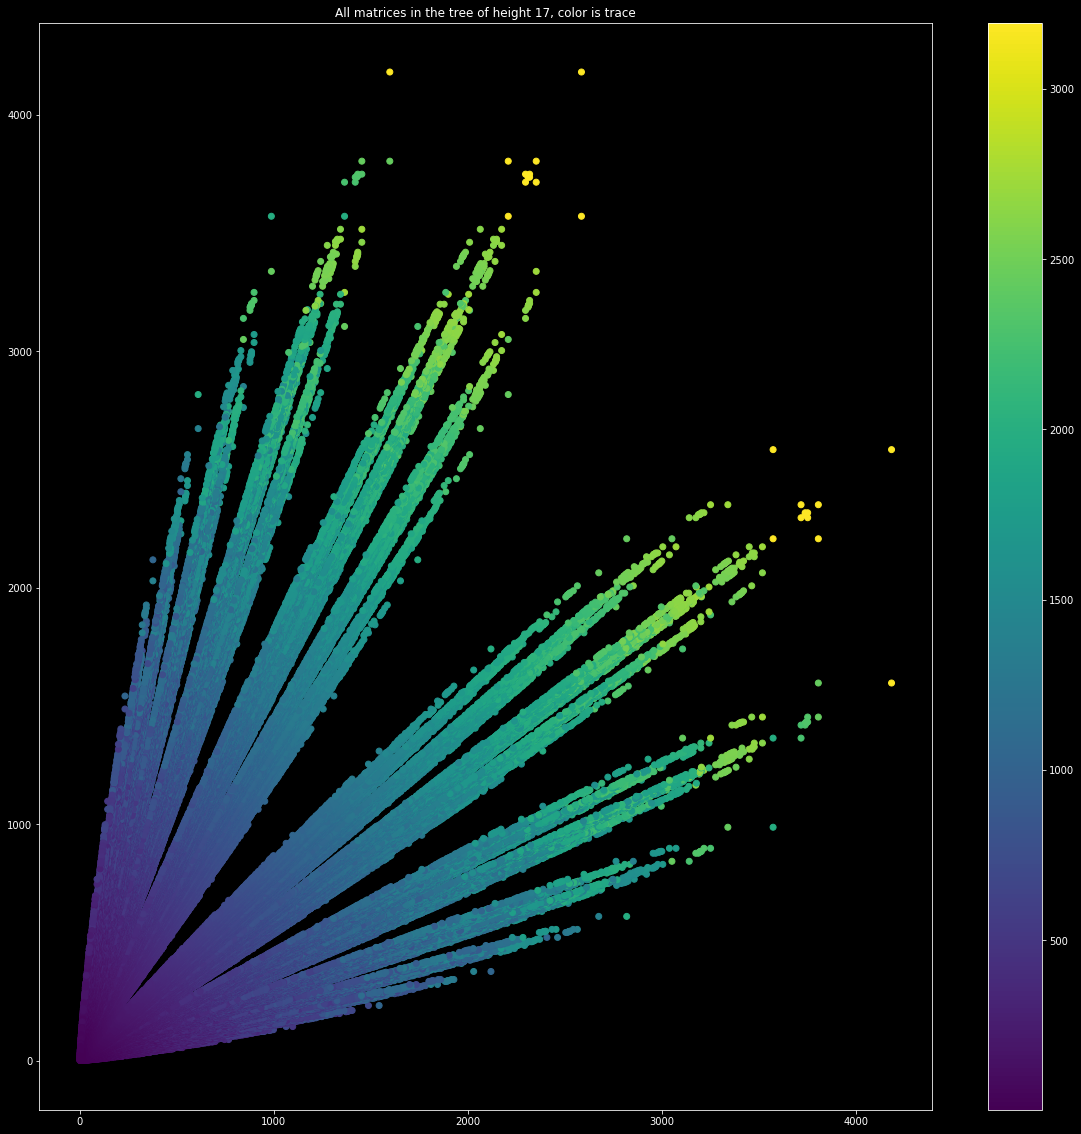

In [20]:
plt.figure(figsize=(20,20))
plt.scatter(all_coords[:,0], all_coords[:,1], c=all_traces)
plt.colorbar()
plt.title("All matrices in the tree of height {}, color is trace".format(BASE_HEIGHT))
plt.savefig('images/matrix_scatter/all_matrices_height{}.png'.format(BASE_HEIGHT))
plt.show()

## Plotting all height 17 matrices in the 100x100 square, color is trace

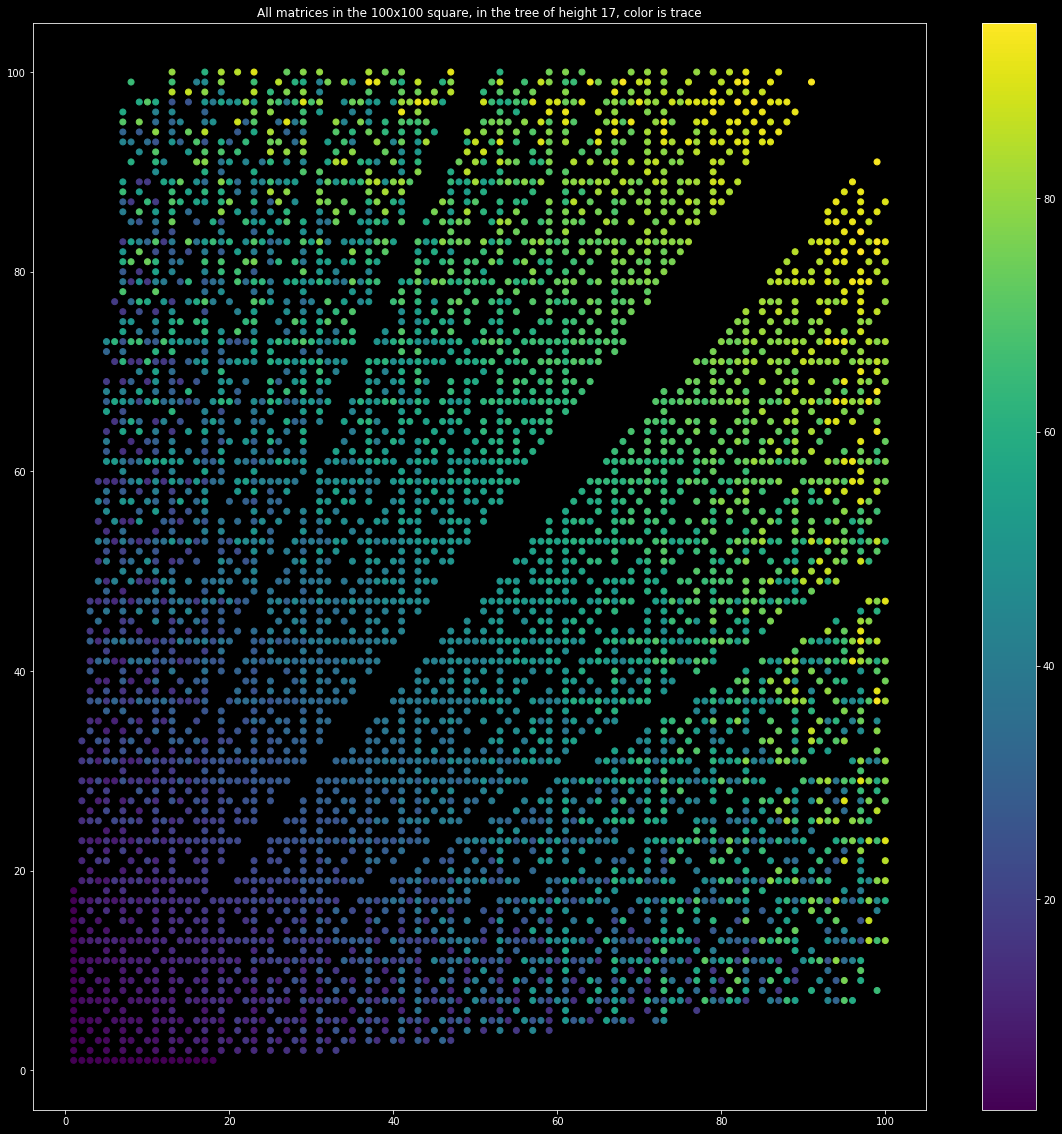

In [26]:
filter_ = (all_coords[:, 0] <= 100)*(all_coords[:, 1] <= 100)
plt.figure(figsize=(20,20))
plt.scatter(all_coords[filter_,0], all_coords[filter_,1], c=all_traces[filter_])
plt.colorbar()
plt.title("All matrices in the 100x100 square, in the tree of height {}, color is trace".format(BASE_HEIGHT))
plt.savefig('images/matrix_scatter/all_matrices_100x100height{}.png'.format(BASE_HEIGHT))
plt.show()

## Plotting matrices per trace

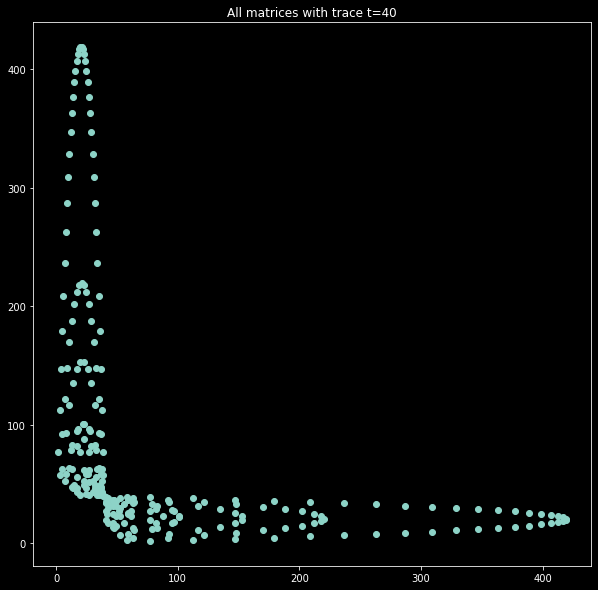

In [132]:
pR.plot_matrix_per_trace(40)

## Plotting matrices per trace and conjugaison classes

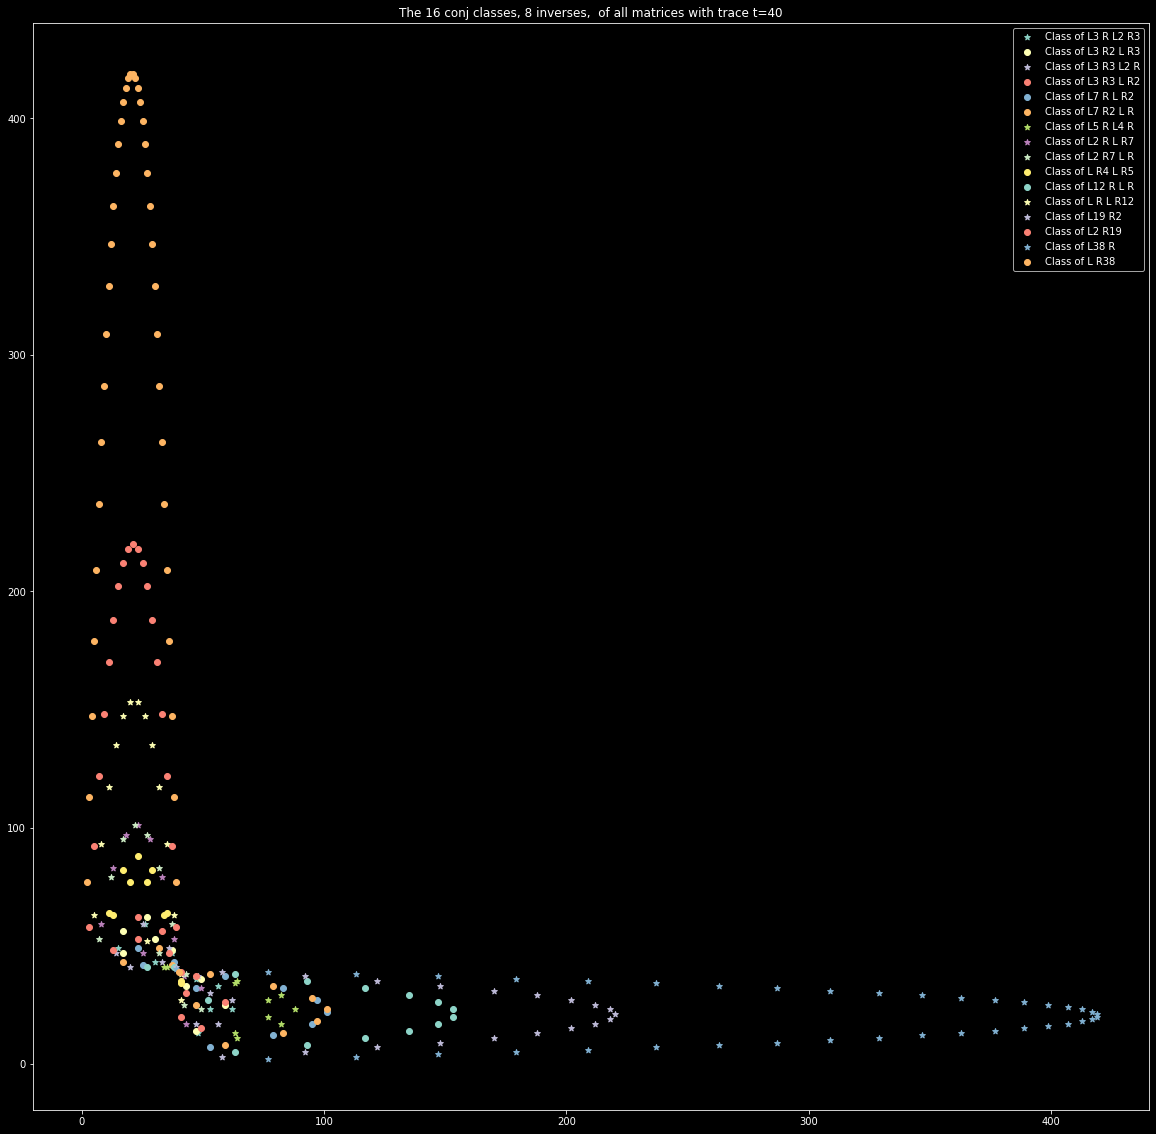

In [133]:
inversibles = ["L38 R", "L3 R3 L2 R", "L R L R12", "L3 R L2 R3", "L19 R2", "L2 R7 L R", "L5 R L4 R", "L2 R L R7"]
pR.plot_matrix_per_trace_with_conj_class(40, inversibles=inversibles, figsize=(20,20))

### Only inversibles

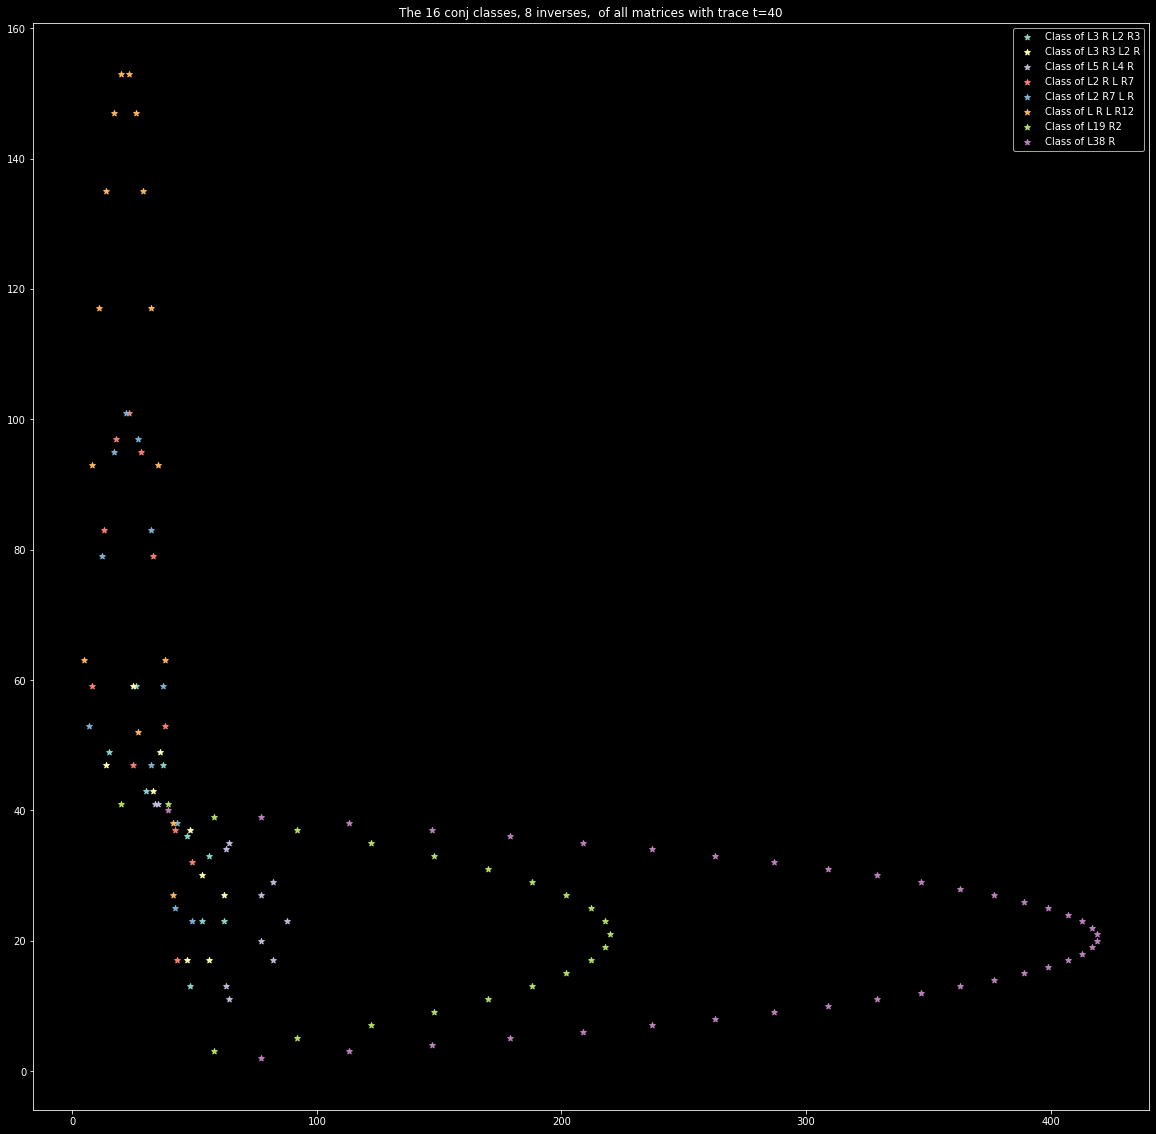

In [134]:
pR.plot_matrix_per_trace_with_conj_class(40, inversibles=inversibles, only_inverse=True, figsize=(20,20))